In [2]:
# import things
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math


2025-01-22 14:15:54.488362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-22 14:15:54.488404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-22 14:15:54.505863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 14:15:54.548276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

if tf.config.list_physical_devices('GPU'):
    print("GPU found. Using GPU for training.")
    os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Use GPU
else:
    print("No GPU found. Using CPU for training.")
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU

GPU found. Using GPU for training.


In [4]:
!nvidia-smi

Wed Jan 22 14:15:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.78                 Driver Version: 550.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:01:00.0 Off |                  Off |
| 30%   33C    P8             24W /  300W |     930MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# REQUIREMENT: Do not add code from Tasks 2 or 4
# REQUIREMENT: All dataset prep (crop/pad/patch/directory structure) must be finalize before attempting this task.
patch_size = 128
patch_dir = 'dataset'

In [6]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
def simple_unet_model(img_height, img_width, img_channels):
    """Define the U-Net architecture."""
    inputs = Input((img_height, img_width, img_channels))

    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

    # Expansive path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer='he_normal')(c9)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss="binary_crossentropy", 
                  metrics=["accuracy", f1])
    return model

In [8]:
# Build U-Net
# REQUIREMENT: Model summary must be visible
IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 3
model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.summary()

2025-01-22 14:15:58.629279: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-22 14:15:58.629660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46339 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['dropout[0][0]']             
                                                                                              

In [9]:
# Step 1: Setup a generator for training
batch_size = 64
train_image_gen = ImageDataGenerator(rescale=1./255)
train_mask_gen = ImageDataGenerator()

train_image_generator = train_image_gen.flow_from_directory(
    os.path.join(patch_dir, 'train_images'),
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,  # Images only
    color_mode='rgb',  # For images
    seed=42
)

train_mask_generator = train_mask_gen.flow_from_directory(
    os.path.join(patch_dir, 'train_masks'),
    target_size=(patch_size, patch_size),
    batch_size=64,
    class_mode=None,  # Masks only
    color_mode='grayscale',  # For masks
    seed=42
)

# Combine generators
def train_generator():
    for img, mask in zip(train_image_generator, train_mask_generator):
        yield img, mask




Found 19392 images belonging to 1 classes.
Found 19392 images belonging to 1 classes.


In [10]:
# Setup a generator for validation
# Step 2: Setup a generator for validation
val_image_gen = ImageDataGenerator(rescale=1./255)
val_mask_gen = ImageDataGenerator()

val_image_generator = val_image_gen.flow_from_directory(
    os.path.join(patch_dir, 'val_images'),
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,  # Images only
    color_mode='rgb',  # For images
    seed=42
)

val_mask_generator = val_mask_gen.flow_from_directory(
    os.path.join(patch_dir, 'val_masks'),
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,  # Masks only
    color_mode='grayscale',  # For masks
    seed=42
)

# Combine generators
def val_generator():
    for img, mask in zip(val_image_generator, val_mask_generator):
        yield img, mask

Found 2880 images belonging to 1 classes.
Found 2880 images belonging to 1 classes.


In [11]:
for img_batch, mask_batch in train_generator():
    print(f"Image batch shape: {img_batch.shape}")
    print(f"Mask batch shape: {mask_batch.shape}")
    break


Image batch shape: (64, 128, 128, 3)
Mask batch shape: (64, 128, 128, 1)


In [12]:
for img_batch, mask_batch in train_generator():
    print(f"Image batch shape: {img_batch.shape}")
    print(f"Mask batch shape: {mask_batch.shape}")
    print(f"Sample mask unique values: {np.unique(mask_batch)}")
    break


Image batch shape: (64, 128, 128, 3)
Mask batch shape: (64, 128, 128, 1)
Sample mask unique values: [0. 1.]


In [13]:
# EarlyStopping()
from keras.callbacks import EarlyStopping
# Step 2: Setup EarlyStopping Callback
cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [14]:
import os

def count_files_in_dir(directory):
    """Count the number of files in a directory."""
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

# Paths to your datasets
train_images_dir = "dataset/train_images/train"
train_masks_dir = "dataset/train_masks/train"
val_images_dir = "dataset/val_images/val"
val_masks_dir = "dataset/val_masks/val"

# Count files
train_images_count = count_files_in_dir(train_images_dir)
train_masks_count = count_files_in_dir(train_masks_dir)
val_images_count = count_files_in_dir(val_images_dir)
val_masks_count = count_files_in_dir(val_masks_dir)

# Print results
print(f"Total training images: {train_images_count}")
print(f"Total training masks: {train_masks_count}")
print(f"Total validation images: {val_images_count}")
print(f"Total validation masks: {val_masks_count}")


Total training images: 19392
Total training masks: 19392
Total validation images: 2880
Total validation masks: 2880


In [15]:
print(train_image_generator.samples)
print(val_image_generator.samples)

19392
2880


In [16]:
# This is where the magic happens
# REQUIREMENT: The epoch logs must be visible showing validation loss and validation f1.
# Step 3: Train the Model
history = model.fit(
    train_generator(),
    validation_data=val_generator(),
    epochs=50,
    steps_per_epoch= math.ceil(train_image_generator.samples / batch_size),  # Adjust this based on the size of training patches
    validation_steps= math.ceil(val_image_generator.samples / batch_size),  # Adjust this based on the size of validation patches
    callbacks=[cb]
)


Epoch 1/50


2025-01-22 14:16:02.845046: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-22 14:16:03.204216: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-01-22 14:16:07.116574: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f83c8870140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-22 14:16:07.116607: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-01-22 14:16:07.125101: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737555367.254382     915 device_compiler.h:186] Compiled cluster using XLA!  This lin

303/303 [==============================] - 85s 209ms/step - loss: 0.6152 - accuracy: 0.9926 - f1: 0.1642 - val_loss: 0.0120 - val_accuracy: 0.9969 - val_f1: 0.4972
Epoch 2/50
303/303 [==============================] - 63s 209ms/step - loss: 0.0160 - accuracy: 0.9959 - f1: 0.4982 - val_loss: 0.0120 - val_accuracy: 0.9970 - val_f1: 0.4403
Epoch 3/50
303/303 [==============================] - 64s 210ms/step - loss: 0.0109 - accuracy: 0.9966 - f1: 0.6351 - val_loss: 0.0105 - val_accuracy: 0.9971 - val_f1: 0.5630
Epoch 4/50
303/303 [==============================] - 64s 211ms/step - loss: 0.0093 - accuracy: 0.9969 - f1: 0.6780 - val_loss: 0.0078 - val_accuracy: 0.9978 - val_f1: 0.5900
Epoch 5/50
303/303 [==============================] - 64s 210ms/step - loss: 0.0080 - accuracy: 0.9972 - f1: 0.7162 - val_loss: 0.0068 - val_accuracy: 0.9978 - val_f1: 0.6815
Epoch 6/50
303/303 [==============================] - 64s 210ms/step - loss: 0.0075 - accuracy: 0.9973 - f1: 0.7297 - val_loss: 0.0059 -

In [ ]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'unet_model_{patch_size}px.h5'
print(example_file_name)
model.save(example_file_name)

dominik_230623_unet_model_128px.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.0040789381600916386
Best validation f1: 0.7937424778938293


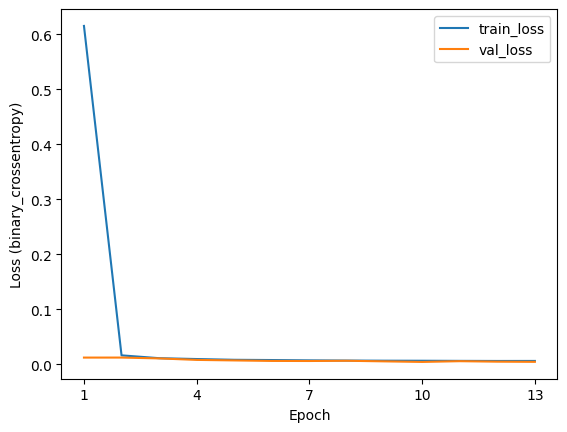

In [19]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

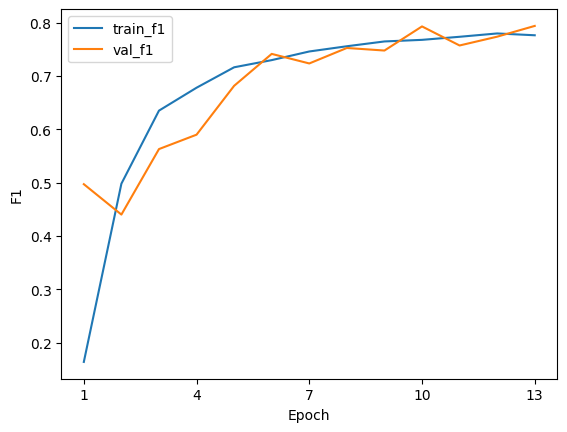

In [20]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))